In [92]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import datetime 
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from prettytable import PrettyTable
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 22})
np.random.seed(42)
from pypfopt.efficient_frontier import EfficientFrontier

# Importing Data and Creating Factors

In [54]:
TRAIN_START = datetime.datetime(2017,12,31)
TRAIN_END = TEST_START = datetime.datetime(2019,12,29)
TEST_END = datetime.datetime(2020,12,27)

Read data for market returns

In [55]:
CC100_Index = pd.read_csv("indexReturns-BITW100.csv")
CC100_Index['date'] = pd.to_datetime(CC100_Index['date']).dt.tz_localize(None)
CC100_Index = CC100_Index.sort_values('date').set_index('date')
CC100_Index = CC100_Index.truncate(before = TRAIN_START,after = TEST_END)
CC100_Index = CC100_Index.resample('W').last()
CC100_Return = CC100_Index.pct_change().fillna(axis = 0, method ='bfill').rename(columns = {"MarketIndex":"MarketReturn"})
CC100_Return = CC100_Return.iloc[1:].copy()
date_list = CC100_Return.index
CC100_Return.set_index(date_list, drop=True, inplace=True)

CC100_Return

,MarketReturn
date,
2018-01-07,0.407408
2018-01-14,-0.102655
2018-01-21,-0.156306
2018-01-28,-0.117886
2018-02-04,-0.202010
...,...
2020-11-29,-0.001030
2020-12-06,0.047348
2020-12-13,-0.013224


Read data for CC used in this project. 
The CC have data as from Jan 2018 to Feb 2021.
There is a total of 68 CC. 

Data is resampled for each CC: The daily data is transformed into weekly data. For the market cap and price, the last value of the day in a week is taken, for the market cap, the mean value for the week is taken and for the volume, the sum of all the volume of each day is taken.

In [56]:
listOfCC = pd.read_csv("Symbols.csv")

ALL_DATA = pd.DataFrame()

for ticker in listOfCC['symbol']:
    
    filename = "CoinGecko_Data/" + ticker + '-usd-max.csv'
    temp = pd.read_csv(filename, parse_dates=['snapped_at'])
    temp = temp.rename(columns = {"snapped_at":"date"})
    temp['date'] = pd.to_datetime(temp['date']).dt.tz_localize(None)
    temp = temp.sort_values('date').set_index('date')
    temp = temp.truncate(before = TRAIN_START,after = TEST_END)
    
    temp1 = pd.to_numeric(temp['price'], downcast="float")
    temp2 = pd.to_numeric(temp['market_cap'], downcast="float")
    temp3 = pd.to_numeric(temp['total_volume'], downcast="float")
        
    temp1 = temp1.resample('W').last()
    temp2 = temp2.resample('W').mean()
    temp3 = temp3.resample('W').sum()
    temp4 = pd.DataFrame(index = [temp1.index])
    temp4 = pd.concat([temp1, temp2, temp3], axis=1)
    
    temp4 = temp4.fillna(axis = 0, method ='bfill')
    temp4['Returns'] = temp4['price'].pct_change()
    temp4['Ticker'] = ticker    
    temp4 = temp4.iloc[1:].copy()    
    ALL_DATA = pd.concat([ALL_DATA,temp4])

ALL_DATA

,price,market_cap,total_volume,Returns,Ticker
date,,,,,
2018-01-07,1.429257,5.478657e+08,200383264.0,0.468908,zrx
2018-01-14,2.090971,1.082455e+09,505867104.0,0.462978,zrx
2018-01-21,1.742747,8.778975e+08,215137936.0,-0.166537,zrx
2018-01-28,1.979192,9.018653e+08,225045584.0,0.135673,zrx
2018-02-04,1.376865,8.179149e+08,142141824.0,-0.304330,zrx
...,...,...,...,...,...
2020-11-29,14.644183,1.307519e+08,164073328.0,0.709512,zen
2020-12-06,12.489144,1.420835e+08,112744968.0,-0.147160,zen
2020-12-13,10.172314,1.121735e+08,65833872.0,-0.185508,zen


The CC data is transformed into a MultiIndex DataFrame.
Moreover, the NVT metric is created.

In [57]:
ALL_DATA.reset_index(drop=False, inplace=True)
dateData = ALL_DATA.set_index(['date', 'Ticker'])
dateData.sort_index(inplace=True)
# Calculate NVT for each date
dateData['NVT'] = dateData['market_cap'] / dateData['total_volume']
dateData

price    market_cap  total_volume   Returns        NVT
date       Ticker                                                            
2018-01-07 ada      1.052854  2.605216e+10  2.750787e+09  0.371556   9.470802
           adx      3.287920  1.825394e+08  1.972941e+08  0.098724   0.925215
           ae       2.737842  4.608177e+08  2.592159e+07  0.942597  17.777370
           ant      8.023694  1.965826e+08  2.687493e+07  0.959480   7.314721
           ardr     1.817910  1.751584e+09  1.332934e+08  0.050602  13.140822
...                      ...           ...           ...       ...        ...
2020-12-27 xrp      0.295383  1.793648e+10  7.558532e+10 -0.489978   0.237301
           xvg      0.007130  1.138970e+08  2.135772e+07 -0.070242   5.332829
           zec     66.474121  7.047802e+08  3.573732e+09 -0.098113   0.197211
           zen     11.915156  1.114705e+08  8.049540e+07 -0.013300   1.384806
           zrx      0.353898  2.756317e+08  4.010995e+08 -0.164775   0.687190

[10608 rows x 5 columns]

Calculate factors SMB and NVT

In [58]:
factors = pd.DataFrame(index=[date_list[0]] , columns=['SMB', 'NVT'])

for i in range(1,156,1):
    this_week = date_list[i]
    last_week = date_list[i-1]
    
    this_week_data = (dateData.loc[this_week]).copy()
    last_week_data = (dateData.loc[last_week]).copy()
    
    m1 = last_week_data['market_cap'].quantile(0.1)
    m2 = last_week_data['market_cap'].quantile(0.9)
    
    n1 = last_week_data['NVT'].quantile(0.1)
    n2 = last_week_data['NVT'].quantile(0.9)
    
    m1_list = (last_week_data.loc[(last_week_data['market_cap'] <= m1)]).index
    m2_list = (last_week_data.loc[(last_week_data['market_cap'] >= m2)]).index
    
    n2_list = (last_week_data.loc[(last_week_data['NVT'] >= n2)]).index
    n1_list = (last_week_data.loc[(last_week_data['NVT'] <= n1)]).index
    
    SMB_factor = this_week_data.Returns.loc[m1_list].mean()
    - this_week_data.Returns.loc[m2_list].mean()
    
    NVT_factor = this_week_data.Returns.loc[n2_list].mean()
    - this_week_data.Returns.loc[n1_list].mean()
    
    df = pd.DataFrame({'SMB': SMB_factor, 'NVT' : NVT_factor}, index = [this_week])
    factors = factors.append(df)
    
factors = pd.concat([factors, CC100_Return], axis=1)
factors = factors.dropna()

Creating each portfolio. Calculate returns of each portfolio.

In [59]:
columns_name = ['SMB1', 'SMB2', 'SMB3', 'SMB4', 'SMB5', 'NVT1', 'NVT2', 'NVT3', 'NVT4', 'NVT5']
portfolio_returns = pd.DataFrame(index=[date_list[0]], columns= columns_name)

for i in range(1,156,1):
    this_week = date_list[i]
    last_week = date_list[i-1]
    
    this_week_data = (dateData.loc[this_week]).copy()
    last_week_data = (dateData.loc[last_week]).copy()
    
    m1 = last_week_data['market_cap'].quantile(0.2)
    m2 = last_week_data['market_cap'].quantile(0.4)
    m3 = last_week_data['market_cap'].quantile(0.6)
    m4 = last_week_data['market_cap'].quantile(0.8)
    
    n1 = last_week_data['NVT'].quantile(0.2)
    n2 = last_week_data['NVT'].quantile(0.4)
    n3 = last_week_data['NVT'].quantile(0.6)
    n4 = last_week_data['NVT'].quantile(0.8)
    
    m1_list = (last_week_data.loc[(last_week_data['market_cap'] <= m1)]).index
    m2_list = (last_week_data.loc[(last_week_data['market_cap'] <= m2) & (last_week_data['market_cap'] > m1)]).index
    m3_list = (last_week_data.loc[(last_week_data['market_cap'] <= m3) & (last_week_data['market_cap'] > m2)]).index
    m4_list = (last_week_data.loc[(last_week_data['market_cap'] <= m4) & (last_week_data['market_cap'] > m3)]).index
    m5_list = (last_week_data.loc[(last_week_data['market_cap'] > m4)]).index
    
    n1_list = (last_week_data.loc[(last_week_data['NVT'] <= n1)]).index
    n2_list = (last_week_data.loc[(last_week_data['NVT'] <= n2) & (last_week_data['NVT'] > n1)]).index
    n3_list = (last_week_data.loc[(last_week_data['NVT'] <= n3) & (last_week_data['NVT'] > n2)]).index
    n4_list = (last_week_data.loc[(last_week_data['NVT'] <= n4) & (last_week_data['NVT'] > n3)]).index
    n5_list = (last_week_data.loc[(last_week_data['NVT'] > n4)]).index
    
    SMB1 = this_week_data.Returns.loc[m1_list].mean()
    SMB2 = this_week_data.Returns.loc[m2_list].mean()
    SMB3 = this_week_data.Returns.loc[m3_list].mean()
    SMB4 = this_week_data.Returns.loc[m4_list].mean()
    SMB5 = this_week_data.Returns.loc[m5_list].mean()
    
    NVT1 = this_week_data.Returns.loc[n1_list].mean()
    NVT2 = this_week_data.Returns.loc[n2_list].mean()
    NVT3 = this_week_data.Returns.loc[n3_list].mean()
    NVT4 = this_week_data.Returns.loc[n4_list].mean()
    NVT5 = this_week_data.Returns.loc[n5_list].mean()
    
    df = pd.DataFrame({'SMB1':SMB1, 'SMB2':SMB2, 'SMB3':SMB3, 'SMB4':SMB4, 'SMB5':SMB5,
                       'NVT1':NVT1, 'NVT2':NVT2, 'NVT3':NVT3,'NVT4':NVT4, 'NVT5':NVT5},
                       index = [this_week])
    portfolio_returns = portfolio_returns.append(df)
portfolio_returns = portfolio_returns.dropna()

In [60]:
date_list = date_list[1:]
portfolio_returns

,SMB1,SMB2,SMB3,SMB4,SMB5,NVT1,NVT2,NVT3,NVT4,NVT5
2018-01-14,0.021870,-0.038312,-0.099153,-0.126006,-0.044925,-0.167748,-0.000871,0.036162,-0.030362,-0.114200
2018-01-21,-0.235131,-0.234492,-0.267948,-0.262206,-0.223426,-0.213971,-0.296796,-0.216037,-0.249478,-0.250463
2018-01-28,0.047099,0.169486,0.081651,0.044809,0.014568,0.002589,0.018544,0.033758,0.098265,0.197493
2018-02-04,-0.292849,-0.186733,-0.294047,-0.265792,-0.275624,-0.296842,-0.240209,-0.276282,-0.246657,-0.257508
2018-02-11,-0.095558,-0.128369,-0.130612,-0.085469,-0.026658,-0.009932,-0.085405,-0.136755,-0.105614,-0.127330
...,...,...,...,...,...,...,...,...,...,...
2020-11-29,0.034567,0.044498,0.090385,0.000070,0.077234,-0.027064,0.025708,0.087167,0.135418,0.033850
2020-12-06,0.091747,0.088727,0.057174,0.032436,0.051728,0.044003,0.075450,0.025164,0.051352,0.126247
2020-12-13,-0.052792,-0.099473,-0.077779,-0.075476,-0.054445,-0.090480,-0.094616,-0.057314,-0.055486,-0.060294
2020-12-20,0.161581,0.088575,0.157834,0.113667,0.170883,0.157980,0.070738,0.167495,0.147438,0.150027


Merging the portfolios' returns with the factors. Splitting data to train data and test data.

In [61]:
portfolio_returns = pd.concat([portfolio_returns, factors], axis=1)
portfolio_returns_TEST = portfolio_returns.loc[TEST_START:].copy()
portfolio_returns = portfolio_returns.loc[:TRAIN_END].copy()

In [114]:
trial_result = []
for ticker in columns_name:
    French_model = smf.ols(formula = ticker+' ~ MarketReturn + SMB + NVT', data = portfolio_returns)
    French_fit = French_model.fit()
    trial_result.append(French_fit)

In [119]:
stargazer = Stargazer(trial_result[0:5])
stargazer.show_model_numbers(False)
stargazer.custom_columns(["SMB1", "SMB2","SMB3", "SMB4","SMB5"], [1,1,1,1,1])
stargazer.rename_covariates({'MarketReturn': 'Market Return'})
HTML(stargazer.render_html())

In [117]:
stargazer = Stargazer(trial_result[5:10])
stargazer.show_model_numbers(False)
stargazer.custom_columns(["NVT1", "NVT2","NVT3", "NVT4","NVT5"], [1,1,1,1,1])
stargazer.rename_covariates({'MarketReturn': 'Market Return'})
HTML(stargazer.render_html())

# Investment Strategy

In [75]:
cumulative_returns = (portfolio_returns_TEST + 1).cumprod()
cumulative_returns

,SMB1,SMB2,SMB3,SMB4,SMB5,NVT1,NVT2,NVT3,NVT4,NVT5,SMB,NVT,MarketReturn
2019-12-29,0.974436,0.976704,0.981263,0.997515,1.028973,1.034214,1.003261,0.984762,0.981596,0.955818,0.957463,0.964393,0.999740
2020-01-05,1.037057,0.985337,0.990864,1.017032,1.053149,1.043468,1.046853,0.989723,1.028180,0.980210,1.043554,0.997259,1.009089
2020-01-12,1.015653,1.015681,1.029845,1.086561,1.175386,1.135945,1.074604,1.056276,1.044505,1.011204,1.022087,1.076757,1.103032
2020-01-19,1.155489,1.184463,1.285900,1.417635,1.450220,1.463236,1.258175,1.349706,1.213519,1.195832,1.155039,1.176176,1.194051
2020-01-26,1.167696,1.159709,1.192187,1.333973,1.358044,1.360922,1.193789,1.350049,1.136682,1.167017,1.218481,1.182948,1.188316
2020-02-02,1.268054,1.391091,1.459907,1.543609,1.603333,1.616123,1.319313,1.664029,1.333307,1.335028,1.266996,1.339101,1.328534
2020-02-09,1.769598,1.593243,1.695930,1.837807,1.811984,1.883888,1.564839,1.916448,1.842369,1.541326,1.978106,1.519759,1.442418
2020-02-16,1.924677,1.956501,2.001712,1.873825,1.917494,1.977326,1.750635,2.224988,2.200738,1.625505,1.876744,1.607327,1.420035
2020-02-23,1.704366,1.885801,1.785434,1.719882,1.745466,1.798623,1.643464,1.957486,1.984550,1.522442,1.662590,1.658729,1.445576
2020-03-01,1.501705,1.568771,1.505374,1.397650,1.469014,1.455925,1.413223,1.636917,1.704657,1.295782,1.550059,1.477620,1.210137


In [76]:
x2 = PrettyTable(["","SMB1", "SMB2","SMB3", "SMB4","SMB5"])
x2.padding_width = 1
y2 = round(cumulative_returns.loc[:,'SMB1': 'SMB5'].iloc[-1] , 3).tolist()
y2 = list(np.around(np.array(y2),4))
y2 = ["Total Return"] + y2
x2.add_row(y2)

print(x2)

+--------------+-------+-------+-------+-------+-------+
|              |  SMB1 |  SMB2 |  SMB3 |  SMB4 |  SMB5 |
+--------------+-------+-------+-------+-------+-------+
| Total Return | 8.276 | 3.549 | 2.575 | 2.513 | 3.167 |
+--------------+-------+-------+-------+-------+-------+


Text(0, 0.5, 'Cumulative Returns')

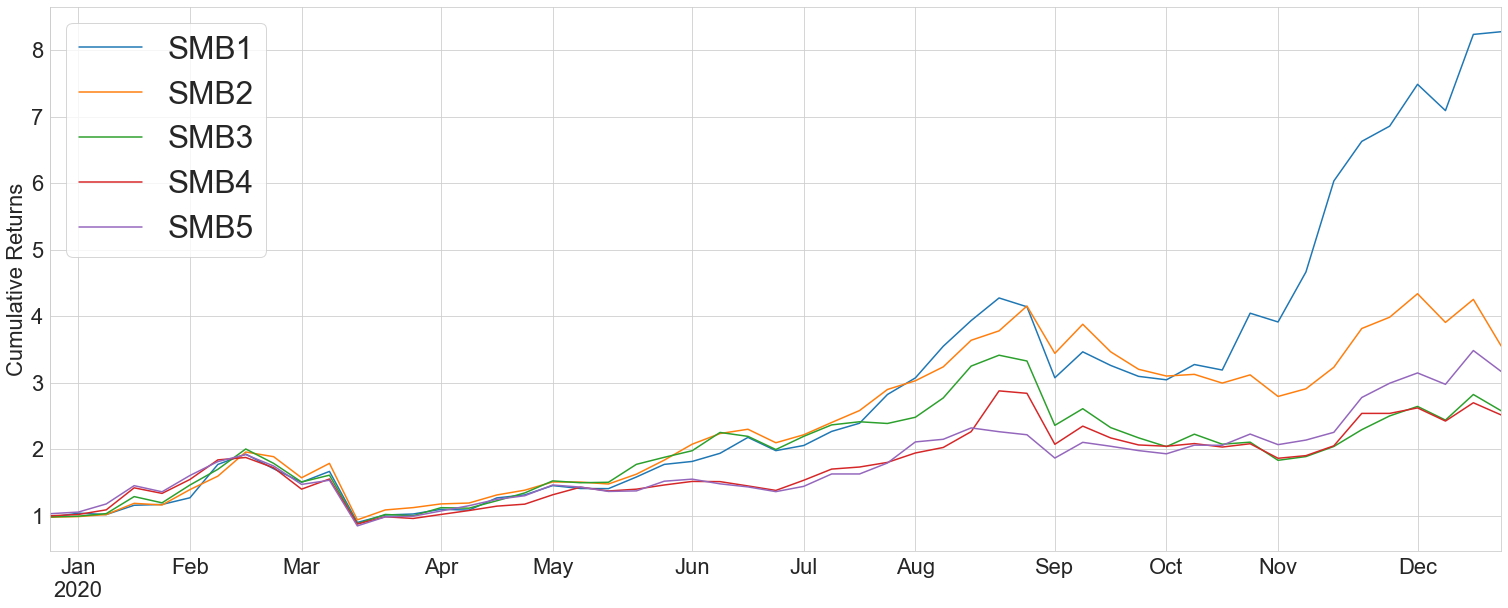

In [77]:
df_tmp=cumulative_returns.loc[:,'SMB1':'SMB5']
df_tmp.plot(figsize = (26,10))
plt.legend(fontsize='x-large', title_fontsize='40')
plt.ylabel('Cumulative Returns')  

In [78]:
x2 = PrettyTable(["","NVT1", "NVT2","NVT3", "NVT4","NVT5"])
x2.padding_width = 1
y2 = round(cumulative_returns.loc[:,'NVT1': 'NVT5'].iloc[-1] , 3).tolist()
y2 = list(np.around(np.array(y2),4))
y2 = ["Total Return"] + y2
x2.add_row(y2)

print(x2)

+--------------+-------+-------+-------+-------+-------+
|              |  NVT1 |  NVT2 |  NVT3 |  NVT4 |  NVT5 |
+--------------+-------+-------+-------+-------+-------+
| Total Return | 2.533 | 2.632 | 4.569 | 5.298 | 4.083 |
+--------------+-------+-------+-------+-------+-------+


Text(0, 0.5, 'Cumulative Returns')

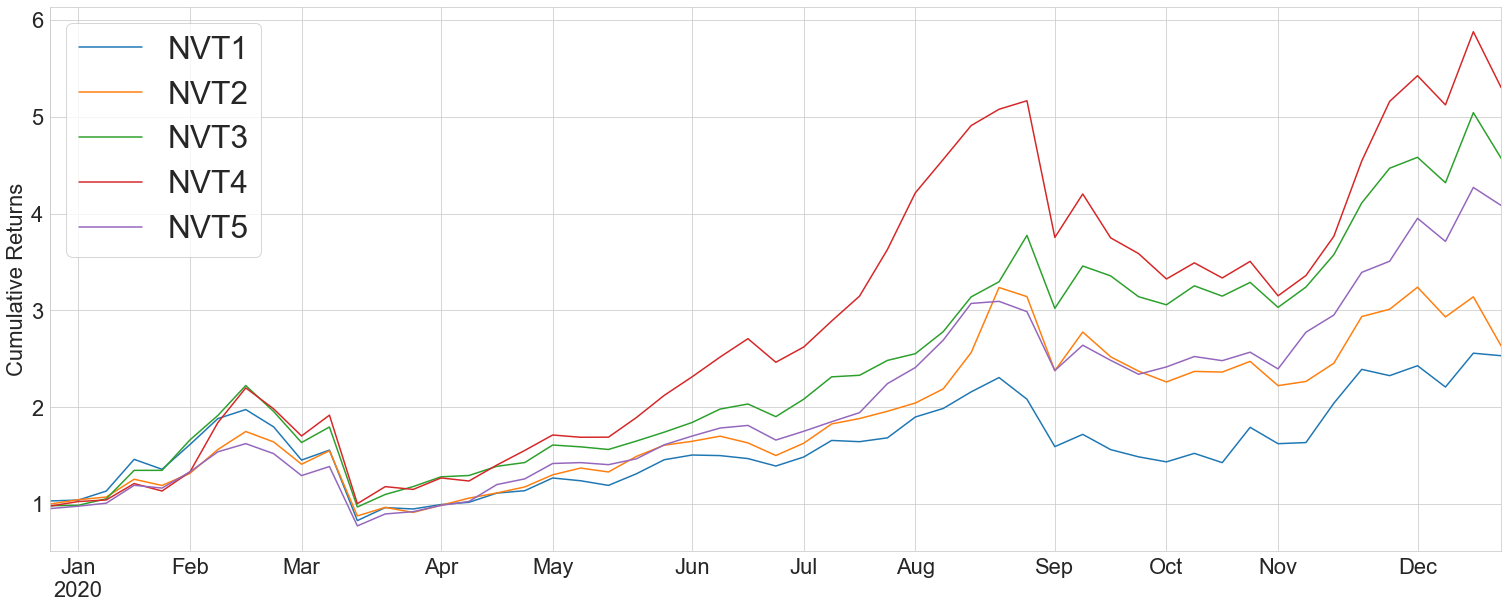

In [79]:
df_tmp=cumulative_returns.loc[:,'NVT1':'NVT5']
df_tmp.plot(figsize = (26,10))
plt.legend(fontsize='x-large', title_fontsize='40')
plt.ylabel('Cumulative Returns')

In [85]:
empirical_results = pd.DataFrame(columns=cumulative_returns.columns, index=['Return','Sharpe_ratio','Calmar_ratio','Tail_ratio'])

for column in cumulative_returns.columns: 
    
    empirical_results.loc['Return'][column] =  cumulative_returns.loc['2020-12-27',column]
    empirical_results.loc['Sharpe_ratio'][column] = empyrical.sharpe_ratio(portfolio_returns_TEST.loc[:,column],risk_free=0,period = 'weekly')
    empirical_results.loc['Calmar_ratio'][column] = empyrical.calmar_ratio(portfolio_returns_TEST.loc[:,column],period = 'weekly')
    empirical_results.loc['Tail_ratio'][column] = empyrical.tail_ratio(portfolio_returns_TEST.loc[:,column])
    
empirical_results = (empirical_results.T)
empirical_results = (empirical_results.iloc[:-3])

In [120]:
print(empirical_results.iloc[:5].to_latex()) #.to_latex()

\begin{tabular}{lllll}
\toprule
{} &    Return & Sharpe\_ratio & Calmar\_ratio & Tail\_ratio \\
\midrule
SMB1 &  8.276246 &     2.759109 &    13.019165 &   1.914115 \\
SMB2 &  3.548646 &     1.968592 &     4.726183 &   1.032953 \\
SMB3 &  2.575258 &     1.535707 &     2.723877 &   1.279675 \\
SMB4 &   2.51281 &     1.519291 &     2.752128 &   1.518993 \\
SMB5 &  3.166602 &     1.874672 &     3.752872 &   1.517871 \\
\bottomrule
\end{tabular}



In [121]:
print(empirical_results.iloc[5:].to_latex()) #.to_latex()

\begin{tabular}{lllll}
\toprule
{} &    Return & Sharpe\_ratio & Calmar\_ratio & Tail\_ratio \\
\midrule
NVT1 &  2.532585 &     1.513183 &     2.568798 &   1.576046 \\
NVT2 &  2.631828 &      1.60774 &     3.184298 &   1.188619 \\
NVT3 &  4.568936 &     2.286251 &      6.10697 &   1.188555 \\
NVT4 &  5.297736 &      2.27576 &     7.615459 &   1.508215 \\
NVT5 &  4.082551 &     2.249197 &     5.699305 &   1.444581 \\
\bottomrule
\end{tabular}

